In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai numpy

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [3]:
import re
import uuid

from langchain_core.tools import StructuredTool


def create_tool(company: str) -> dict:
    """Create schema for a placeholder tool."""
    formatted_company = re.sub(r"[^\w\s]", "", company).replace(" ", "_")

    def company_tool(year: int) -> str:
        return f"{company} had revenues of $100 in {year}."

    return StructuredTool.from_function(
        company_tool,
        name=formatted_company,
        description=f"Information about {company}",
    )


s_and_p_500_companies = [  # Abbreviated list for demonstration purposes
    "3M",
    "A.O. Smith",
    "Abbott",
    "Accenture",
    "Advanced Micro Devices",
    "Yum! Brands",
    "Zebra Technologies",
    "Zimmer Biomet",
    "Zoetis",
]

tool_registry = {
    str(uuid.uuid4()): create_tool(company) for company in s_and_p_500_companies
}

In [13]:
tool_registry

{'d3b5c733-d62e-4b65-9e37-31adb32b3a86': StructuredTool(name='3M', description='Information about 3M', args_schema=<class 'pydantic.v1.main.3MSchema'>, func=<function create_tool.<locals>.company_tool at 0x780f085ee3e0>),
 '66a6bcbc-5e04-4385-a6a5-3a09fb1f3a26': StructuredTool(name='AO_Smith', description='Information about A.O. Smith', args_schema=<class 'pydantic.v1.main.AO_SmithSchema'>, func=<function create_tool.<locals>.company_tool at 0x780ef7f96200>),
 'e3a2df4d-0efc-40ad-aa1a-efecbcd6560c': StructuredTool(name='Abbott', description='Information about Abbott', args_schema=<class 'pydantic.v1.main.AbbottSchema'>, func=<function create_tool.<locals>.company_tool at 0x780ef7744f40>),
 '021f8dac-01aa-44e1-bc88-41464d6ebf7d': StructuredTool(name='Accenture', description='Information about Accenture', args_schema=<class 'pydantic.v1.main.AccentureSchema'>, func=<function create_tool.<locals>.company_tool at 0x780ef7745940>),
 '15ae763d-3d86-4741-924a-4ca3d2cb380e': StructuredTool(nam

In [4]:
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore, VectorStore
from langchain_openai import OpenAIEmbeddings

tool_documents = [
    Document(
        page_content=tool.description,
        id=id,
        metadata={"tool_name": tool.name},
    )
    for id, tool in tool_registry.items()
]

vector_store = InMemoryVectorStore(embedding=OpenAIEmbeddings())
document_ids = vector_store.add_documents(tool_documents)

In [30]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]


graph_builder = StateGraph(State)

tools = list(tool_registry.values())
llm = ChatOpenAI()


def agent(state: State):
    selected_tools = [tool_registry[id] for id in state["selected_tools"]]
    llm_with_tools = llm.bind_tools(selected_tools)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


def select_tools(state: State):
    last_user_message = state["messages"][-1]
    query = last_user_message.content
    print (query)
    tool_documents = vector_store.similarity_search(query)
    print ("tool_documents: ", tool_documents)
    return {"selected_tools": [document.id for document in tool_documents]}


graph_builder.add_node("agent", agent)
graph_builder.add_node("select_tools", select_tools)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
)
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("select_tools", "agent")
graph_builder.add_edge(START, "select_tools")
graph = graph_builder.compile()

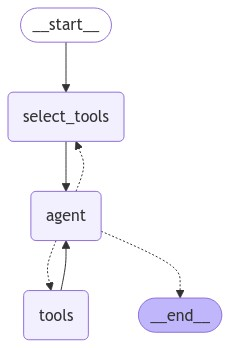

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
# user_input = "Can you give me some information about AMD in 2022?"
user_input = "How are you?"

result = graph.invoke({"messages": [("user", user_input)]})
for message in result["messages"]:
    message.pretty_print()

How are you?
tool_documents:  [Document(id='e3a2df4d-0efc-40ad-aa1a-efecbcd6560c', metadata={'tool_name': 'Abbott'}, page_content='Information about Abbott'), Document(id='d3b5c733-d62e-4b65-9e37-31adb32b3a86', metadata={'tool_name': '3M'}, page_content='Information about 3M'), Document(id='1b0a1907-e7a8-41db-8796-f28e1cdbbc67', metadata={'tool_name': 'Yum_Brands'}, page_content='Information about Yum! Brands'), Document(id='66a6bcbc-5e04-4385-a6a5-3a09fb1f3a26', metadata={'tool_name': 'AO_Smith'}, page_content='Information about A.O. Smith')]
================================ Human Message =================================

How are you?
================================== Ai Message ==================================

I'm here and ready to assist you with any questions or tasks you have. How can I help you today?


In [20]:

[tool_registry[id] for id in state["selected_tools"]]

NameError: name 'state' is not defined

In [14]:
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.pregel.retry import RetryPolicy

# NOTE:
# - if you're using langchain-core >= 0.3, you need to use pydantic v2
# - if you're using langchain-core >= 0.2,<0.3, you need to use pydantic v1
from langchain_core import __version__ as core_version
from packaging import version

core_version = version.parse(core_version)
if (core_version.major, core_version.minor) < (0, 3):
    from pydantic.v1 import BaseModel, Field
else:
    from pydantic import BaseModel, Field


class QueryForTools(BaseModel):
    """Generate a query for additional tools."""

    query: str = Field(..., description="Query for additional tools.")


def select_tools(state: State):
    last_message = state["messages"][-1]
    hack_remove_tool_condition = False
    if isinstance(last_message, HumanMessage):
        query = last_message.content
        hack_remove_tool_condition = True
    else:
        assert isinstance(last_message, ToolMessage)
        system = SystemMessage(
            "Given this conversation, generate a query for additional tools. "
            "The query should be a short string containing what type of information "
            "is needed. If no further information is needed, "
            "set more_information_needed False and populate a blank string for the query."
        )
        input_messages = [system] + state["messages"]
        response = llm.bind_tools([QueryForTools], tool_choice=True).invoke(
            input_messages
        )
        query = response.tool_calls[0]["args"]["query"]
    tool_documents = vector_store.similarity_search(query)
    if hack_remove_tool_condition:
        # Remove needed tool
        selected_tools = [
            document.id
            for document in tool_documents
            if document.metadata["tool_name"] != "Advanced_Micro_Devices"
        ]
    else:
        selected_tools = [document.id for document in tool_documents]
    return {"selected_tools": selected_tools}


graph_builder = StateGraph(State)
graph_builder.add_node("agent", agent)
graph_builder.add_node("select_tools", select_tools, retry=RetryPolicy(max_attempts=3))

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
)
graph_builder.add_edge("tools", "select_tools")
graph_builder.add_edge("select_tools", "agent")
graph_builder.add_edge(START, "select_tools")
graph = graph_builder.compile()

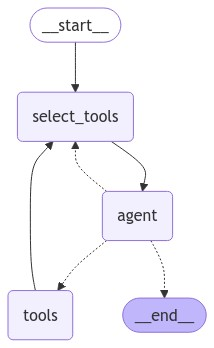

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
user_input = "Tell me a story"
# user_input = "Can you give me some information about AMD in 2022?"

result = graph.invoke({"messages": [("user", user_input)]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Tell me a story
================================== Ai Message ==================================

Once upon a time, in a small village nestled between lush green mountains, there lived a young boy named Leo. Leo was known for his kindness and curiosity. He would spend his days exploring the forests, discovering new plants and animals, and helping the villagers with their daily tasks.

One day, while wandering deep into the forest, Leo stumbled upon a hidden cave. Intrigued, he entered the cave and found a mysterious old book lying on a stone pedestal. The book was filled with ancient symbols and writings that Leo could not understand.

Determined to unravel the secrets of the book, Leo sought the help of the village elder, a wise man named Master Wu. Master Wu studied the book carefully and revealed that it held the key to unlocking a magical portal that could transport them to a distant land filled with 